# COSE474-2024F Deep Learning HW 2
- **Chapter 7**
- 2021170964 박경빈

## 0.1. Installation


In [1]:
!pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 600.6 kB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 2.9 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uni



---



## 7.1. From Fully Connected Layers to Convolutions

To this day,
the models that we have discussed so far
remain appropriate options
when we are dealing with tabular data.
By tabular, we mean that the data consist
of rows corresponding to examples
and columns corresponding to features.
With tabular data, we might anticipate
that the patterns we seek could involve
interactions among the features,
but we do not assume any structure *a priori*
concerning how the features interact.

Sometimes, we truly lack the knowledge to be able to guide the construction of fancier architectures.
In these cases, an MLP
may be the best that we can do.
However, for high-dimensional perceptual data,
such structureless networks can grow unwieldy.

For instance, let's return to our running example
of distinguishing cats from dogs.
Say that we do a thorough job in data collection,
collecting an annotated dataset of one-megapixel photographs.
This means that each input to the network has one million dimensions.
Even an aggressive reduction to one thousand hidden dimensions
would require a fully connected layer
characterized by $10^6 \times 10^3 = 10^9$ parameters.
Unless we have lots of GPUs, a talent
for distributed optimization,
and an extraordinary amount of patience,
learning the parameters of this network
may turn out to be infeasible.

A careful reader might object to this argument
on the basis that one megapixel resolution may not be necessary.
However, while we might be able
to get away with one hundred thousand pixels,
our hidden layer of size 1000 grossly underestimates
the number of hidden units that it takes
to learn good representations of images,
so a practical system will still require billions of parameters.
Moreover, learning a classifier by fitting so many parameters
might require collecting an enormous dataset.
And yet today both humans and computers are able
to distinguish cats from dogs quite well,
seemingly contradicting these intuitions.
That is because images exhibit rich structure
that can be exploited by humans
and machine learning models alike.
Convolutional neural networks (CNNs) are one creative way
that machine learning has embraced for exploiting
some of the known structure in natural images.

### 7.1.1. Invariance

Imagine that we want to detect an object in an image.
It seems reasonable that whatever method
we use to recognize objects should not be overly concerned
with the precise location of the object in the image.
Ideally, our system should exploit this knowledge.
Pigs usually do not fly and planes usually do not swim.
Nonetheless, we should still recognize
a pig were one to appear at the top of the image.
We can draw some inspiration here
from the children's game "Where's Waldo"
(which itself has inspired many real-life imitations, such as that depicted in :numref:`img_waldo`).
The game consists of a number of chaotic scenes
bursting with activities.
Waldo shows up somewhere in each,
typically lurking in some unlikely location.
The reader's goal is to locate him.
Despite his characteristic outfit,
this can be surprisingly difficult,
due to the large number of distractions.
However, *what Waldo looks like*
does not depend upon *where Waldo is located*.
We could sweep the image with a Waldo detector
that could assign a score to each patch,
indicating the likelihood that the patch contains Waldo.
In fact, many object detection and segmentation algorithms
are based on this approach :cite:`Long.Shelhamer.Darrell.2015`.
CNNs systematize this idea of *spatial invariance*,
exploiting it to learn useful representations
with fewer parameters.

We can now make these intuitions more concrete
by enumerating a few desiderata to guide our design
of a neural network architecture suitable for computer vision:

1. In the earliest layers, our network
   should respond similarly to the same patch,
   regardless of where it appears in the image. This principle is called *translation invariance* (or *translation equivariance*).
1. The earliest layers of the network should focus on local regions,
   without regard for the contents of the image in distant regions. This is the *locality* principle.
   Eventually, these local representations can be aggregated
   to make predictions at the whole image level.
1. As we proceed, deeper layers should be able to capture longer-range features of the
   image, in a way similar to higher level vision in nature.

Let's see how this translates into mathematics.

### 7.1.2. Constraining the MLP

To start off, we can consider an MLP
with two-dimensional images $\mathbf{X}$ as inputs
and their immediate hidden representations
$\mathbf{H}$ similarly represented as matrices (they are two-dimensional tensors in code), where both $\mathbf{X}$ and $\mathbf{H}$ have the same shape.
Let that sink in.
We now imagine that not only the inputs but
also the hidden representations possess spatial structure.

Let $[\mathbf{X}]_{i, j}$ and $[\mathbf{H}]_{i, j}$ denote the pixel
at location $(i,j)$
in the input image and hidden representation, respectively.
Consequently, to have each of the hidden units
receive input from each of the input pixels,
we would switch from using weight matrices
(as we did previously in MLPs)
to representing our parameters
as fourth-order weight tensors $\mathsf{W}$.
Suppose that $\mathbf{U}$ contains biases,
we could formally express the fully connected layer as

$$\begin{aligned} \left[\mathbf{H}\right]_{i, j} &= [\mathbf{U}]_{i, j} + \sum_k \sum_l[\mathsf{W}]_{i, j, k, l}  [\mathbf{X}]_{k, l}\\ &=  [\mathbf{U}]_{i, j} +
\sum_a \sum_b [\mathsf{V}]_{i, j, a, b}  [\mathbf{X}]_{i+a, j+b}.\end{aligned}$$

The switch from $\mathsf{W}$ to $\mathsf{V}$ is entirely cosmetic for now
since there is a one-to-one correspondence
between coefficients in both fourth-order tensors.
We simply re-index the subscripts $(k, l)$
such that $k = i+a$ and $l = j+b$.
In other words, we set $[\mathsf{V}]_{i, j, a, b} = [\mathsf{W}]_{i, j, i+a, j+b}$.
The indices $a$ and $b$ run over both positive and negative offsets,
covering the entire image.
For any given location ($i$, $j$) in the hidden representation $[\mathbf{H}]_{i, j}$,
we compute its value by summing over pixels in $x$,
centered around $(i, j)$ and weighted by $[\mathsf{V}]_{i, j, a, b}$. Before we carry on, let's consider the total number of parameters required for a *single* layer in this parametrization: a $1000 \times 1000$ image (1 megapixel) is mapped to a $1000 \times 1000$ hidden representation. This requires $10^{12}$ parameters, far beyond what computers currently can handle.  

### 7.1.2.1. Translation Invariance

Now let's invoke the first principle
established above: translation invariance :cite:`Zhang.ea.1988`.
This implies that a shift in the input $\mathbf{X}$
should simply lead to a shift in the hidden representation $\mathbf{H}$.
This is only possible if $\mathsf{V}$ and $\mathbf{U}$ do not actually depend on $(i, j)$. As such,
we have $[\mathsf{V}]_{i, j, a, b} = [\mathbf{V}]_{a, b}$ and $\mathbf{U}$ is a constant, say $u$.
As a result, we can simplify the definition for $\mathbf{H}$:

$$[\mathbf{H}]_{i, j} = u + \sum_a\sum_b [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}.$$


This is a *convolution*!
We are effectively weighting pixels at $(i+a, j+b)$
in the vicinity of location $(i, j)$ with coefficients $[\mathbf{V}]_{a, b}$
to obtain the value $[\mathbf{H}]_{i, j}$.
Note that $[\mathbf{V}]_{a, b}$ needs many fewer coefficients than $[\mathsf{V}]_{i, j, a, b}$ since it
no longer depends on the location within the image. Consequently, the number of parameters required is no longer $10^{12}$ but a much more reasonable $4 \times 10^6$: we still have the dependency on $a, b \in (-1000, 1000)$. In short, we have made significant progress. Time-delay neural networks (TDNNs) are some of the first examples to exploit this idea :cite:`Waibel.Hanazawa.Hinton.ea.1989`.

### 7.1.2.2. Locality

Now let's invoke the second principle: locality.
As motivated above, we believe that we should not have
to look very far away from location $(i, j)$
in order to glean relevant information
to assess what is going on at $[\mathbf{H}]_{i, j}$.
This means that outside some range $|a|> \Delta$ or $|b| > \Delta$,
we should set $[\mathbf{V}]_{a, b} = 0$.
Equivalently, we can rewrite $[\mathbf{H}]_{i, j}$ as

$$[\mathbf{H}]_{i, j} = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}.$$
:eqlabel:`eq_conv-layer`

This reduces the number of parameters from $4 \times 10^6$ to $4 \Delta^2$, where $\Delta$ is typically smaller than $10$. As such, we reduced the number of parameters by another four orders of magnitude. Note that :eqref:`eq_conv-layer`, is what is called, in a nutshell, a *convolutional layer*.
*Convolutional neural networks* (CNNs)
are a special family of neural networks that contain convolutional layers.
In the deep learning research community,
$\mathbf{V}$ is referred to as a *convolution kernel*,
a *filter*, or simply the layer's *weights* that are learnable parameters.

While previously, we might have required billions of parameters
to represent just a single layer in an image-processing network,
we now typically need just a few hundred, without
altering the dimensionality of either
the inputs or the hidden representations.
The price paid for this drastic reduction in parameters
is that our features are now translation invariant
and that our layer can only incorporate local information,
when determining the value of each hidden activation.
All learning depends on imposing inductive bias.
When that bias agrees with reality,
we get sample-efficient models
that generalize well to unseen data.
But of course, if those biases do not agree with reality,
e.g., if images turned out not to be translation invariant,
our models might struggle even to fit our training data.

This dramatic reduction in parameters brings us to our last desideratum,
namely that deeper layers should represent larger and more complex aspects
of an image. This can be achieved by interleaving nonlinearities and convolutional
layers repeatedly.

### 7.1.3. Convolutions

Let's briefly review why :eqref:`eq_conv-layer` is called a convolution.
In mathematics, the *convolution* between two functions :cite:`Rudin.1973`,
say $f, g: \mathbb{R}^d \to \mathbb{R}$ is defined as

$$(f * g)(\mathbf{x}) = \int f(\mathbf{z}) g(\mathbf{x}-\mathbf{z}) d\mathbf{z}.$$

That is, we measure the overlap between $f$ and $g$
when one function is "flipped" and shifted by $\mathbf{x}$.
Whenever we have discrete objects, the integral turns into a sum.
For instance, for vectors from
the set of square-summable infinite-dimensional vectors
with index running over $\mathbb{Z}$ we obtain the following definition:

$$(f * g)(i) = \sum_a f(a) g(i-a).$$

For two-dimensional tensors, we have a corresponding sum
with indices $(a, b)$ for $f$ and $(i-a, j-b)$ for $g$, respectively:

$$(f * g)(i, j) = \sum_a\sum_b f(a, b) g(i-a, j-b).$$
:eqlabel:`eq_2d-conv-discrete`

This looks similar to :eqref:`eq_conv-layer`, with one major difference.
Rather than using $(i+a, j+b)$, we are using the difference instead.
Note, though, that this distinction is mostly cosmetic
since we can always match the notation between
:eqref:`eq_conv-layer` and :eqref:`eq_2d-conv-discrete`.
Our original definition in :eqref:`eq_conv-layer` more properly
describes a *cross-correlation*.
We will come back to this in the following section.

### 7.1.4. Channels

Returning to our Waldo detector, let's see what this looks like.
The convolutional layer picks windows of a given size
and weighs intensities according to the filter $\mathsf{V}$, as demonstrated in :numref:`fig_waldo_mask`.
We might aim to learn a model so that
wherever the "waldoness" is highest,
we should find a peak in the hidden layer representations.

There is just one problem with this approach.
So far, we blissfully ignored that images consist
of three channels: red, green, and blue.
In sum, images are not two-dimensional objects
but rather third-order tensors,
characterized by a height, width, and channel,
e.g., with shape $1024 \times 1024 \times 3$ pixels.
While the first two of these axes concern spatial relationships,
the third can be regarded as assigning
a multidimensional representation to each pixel location.
We thus index $\mathsf{X}$ as $[\mathsf{X}]_{i, j, k}$.
The convolutional filter has to adapt accordingly.
Instead of $[\mathbf{V}]_{a,b}$, we now have $[\mathsf{V}]_{a,b,c}$.

Moreover, just as our input consists of a third-order tensor,
it turns out to be a good idea to similarly formulate
our hidden representations as third-order tensors $\mathsf{H}$.
In other words, rather than just having a single hidden representation
corresponding to each spatial location,
we want an entire vector of hidden representations
corresponding to each spatial location.
We could think of the hidden representations as comprising
a number of two-dimensional grids stacked on top of each other.
As in the inputs, these are sometimes called *channels*.
They are also sometimes called *feature maps*,
as each provides a spatialized set
of learned features for the subsequent layer.
Intuitively, you might imagine that at lower layers that are closer to inputs,
some channels could become specialized to recognize edges while
others could recognize textures.

To support multiple channels in both inputs ($\mathsf{X}$) and hidden representations ($\mathsf{H}$),
we can add a fourth coordinate to $\mathsf{V}$: $[\mathsf{V}]_{a, b, c, d}$.
Putting everything together we have:

$$[\mathsf{H}]_{i,j,d} = \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} \sum_c [\mathsf{V}]_{a, b, c, d} [\mathsf{X}]_{i+a, j+b, c},$$
:eqlabel:`eq_conv-layer-channels`

where $d$ indexes the output channels in the hidden representations $\mathsf{H}$. The subsequent convolutional layer will go on to take a third-order tensor, $\mathsf{H}$, as input.
We take
:eqref:`eq_conv-layer-channels`,
because of its generality, as
the definition of a convolutional layer for multiple channels, where $\mathsf{V}$ is a kernel or filter of the layer.

There are still many operations that we need to address.
For instance, we need to figure out how to combine all the hidden representations
to a single output, e.g., whether there is a Waldo *anywhere* in the image.
We also need to decide how to compute things efficiently,
how to combine multiple layers,
appropriate activation functions,
and how to make reasonable design choices
to yield networks that are effective in practice.
We turn to these issues in the remainder of the chapter.

## 7.2. Convolutions for Images

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

### 7.2.1. The Cross-Correlation Operation

Recall that strictly speaking, convolutional layers
are a  misnomer, since the operations they express
are more accurately described as cross-correlations.
Based on our descriptions of convolutional layers in :numref:`sec_why-conv`,
in such a layer, an input tensor
and a kernel tensor are combined
to produce an output tensor through a (**cross-correlation operation.**)

Let's ignore channels for now and see how this works
with two-dimensional data and hidden representations.
In :numref:`fig_correlation`,
the input is a two-dimensional tensor
with a height of 3 and width of 3.
We mark the shape of the tensor as $3 \times 3$ or ($3$, $3$).
The height and width of the kernel are both 2.
The shape of the *kernel window* (or *convolution window*)
is given by the height and width of the kernel
(here it is $2 \times 2$).

![Two-dimensional cross-correlation operation. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times0+1\times1+3\times2+4\times3=19$.](http://d2l.ai/_images/correlation.svg)
:label:`fig_correlation`

In the two-dimensional cross-correlation operation,
we begin with the convolution window positioned
at the upper-left corner of the input tensor
and slide it across the input tensor,
both from left to right and top to bottom.
When the convolution window slides to a certain position,
the input subtensor contained in that window
and the kernel tensor are multiplied elementwise
and the resulting tensor is summed up
yielding a single scalar value.
This result gives the value of the output tensor
at the corresponding location.
Here, the output tensor has a height of 2 and width of 2
and the four elements are derived from
the two-dimensional cross-correlation operation:

$$
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.
$$

Note that along each axis, the output size
is slightly smaller than the input size.
Because the kernel has width and height greater than $1$,
we can only properly compute the cross-correlation
for locations where the kernel fits wholly within the image,
the output size is given by the input size $n_\textrm{h} \times n_\textrm{w}$
minus the size of the convolution kernel $k_\textrm{h} \times k_\textrm{w}$
via

$$(n_\textrm{h}-k_\textrm{h}+1) \times (n_\textrm{w}-k_\textrm{w}+1).$$

This is the case since we need enough space
to "shift" the convolution kernel across the image.
Later we will see how to keep the size unchanged
by padding the image with zeros around its boundary
so that there is enough space to shift the kernel.
Next, we implement this process in the `corr2d` function,
which accepts an input tensor `X` and a kernel tensor `K`
and returns an output tensor `Y`.

In [4]:
def corr2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [5]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 7.2.2. Convolutional Layers

In [6]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

### 7.2.3. Object Edge Detection in Images

In [7]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

Next, we construct a kernel `K` with a height of 1 and a width of 2.
When we perform the cross-correlation operation with the input,
if the horizontally adjacent elements are the same,
the output is 0. Otherwise, the output is nonzero.
Note that this kernel is a special case of a finite difference operator. At location $(i,j)$ it computes $x_{i,j} - x_{(i+1),j}$, i.e., it computes the difference between the values of horizontally adjacent pixels. This is a discrete approximation of the first derivative in the horizontal direction. After all, for a function $f(i,j)$ its derivative $-\partial_i f(i,j) = \lim_{\epsilon \to 0} \frac{f(i,j) - f(i+\epsilon,j)}{\epsilon}$. Let's see how this works in practice.

In [8]:
K = torch.tensor([[1.0, -1.0]])

We are ready to perform the cross-correlation operation
with arguments `X` (our input) and `K` (our kernel).
As you can see, [**we detect $1$ for the edge from white to black
and $-1$ for the edge from black to white.**]
All other outputs take value $0$.

In [9]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

We can now apply the kernel to the transposed image. As expected, it vanishes. The kernel K only detects vertical edges.

In [10]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### 7.2.4. Learning a Kernel

Designing an edge detector by finite differences `[1, -1]` is neat
if we know this is precisely what we are looking for.
However, as we look at larger kernels,
and consider successive layers of convolutions,
it might be impossible to specify
precisely what each filter should be doing manually.

Now let's see whether we can [**learn the kernel that generated `Y` from `X`**]
by looking at the input--output pairs only.
We first construct a convolutional layer
and initialize its kernel as a random tensor.
Next, in each iteration, we will use the squared error
to compare `Y` with the output of the convolutional layer.
We can then calculate the gradient to update the kernel.
For the sake of simplicity,
in the following
we use the built-in class
for two-dimensional convolutional layers
and ignore the bias.


In [11]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 7.803
epoch 4, loss 1.545
epoch 6, loss 0.356
epoch 8, loss 0.099
epoch 10, loss 0.033


Note that the error has dropped to a small value after 10 iterations. Now we will take a look at the kernel tensor we learned.


In [12]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0035, -0.9693]])

### 7.2.5. Cross-Correlation and Convolution

Recall our observation from :numref:`sec_why-conv` of the correspondence
between the cross-correlation and convolution operations.
Here let's continue to consider two-dimensional convolutional layers.
What if such layers
perform strict convolution operations
as defined in :eqref:`eq_2d-conv-discrete`
instead of cross-correlations?
In order to obtain the output of the strict *convolution* operation, we only need to flip the two-dimensional kernel tensor both horizontally and vertically, and then perform the *cross-correlation* operation with the input tensor.

It is noteworthy that since kernels are learned from data in deep learning,
the outputs of convolutional layers remain unaffected
no matter such layers
perform
either the strict convolution operations
or the cross-correlation operations.

To illustrate this, suppose that a convolutional layer performs *cross-correlation* and learns the kernel in :numref:`fig_correlation`, which is here denoted as the matrix $\mathbf{K}$.
Assuming that other conditions remain unchanged,
when this layer instead performs strict *convolution*,
the learned kernel $\mathbf{K}'$ will be the same as $\mathbf{K}$
after $\mathbf{K}'$ is
flipped both horizontally and vertically.
That is to say,
when the convolutional layer
performs strict *convolution*
for the input in :numref:`fig_correlation`
and $\mathbf{K}'$,
the same output in :numref:`fig_correlation`
(cross-correlation of the input and $\mathbf{K}$)
will be obtained.

In keeping with standard terminology in deep learning literature,
we will continue to refer to the cross-correlation operation
as a convolution even though, strictly-speaking, it is slightly different.
Furthermore,
we use the term *element* to refer to
an entry (or component) of any tensor representing a layer representation or a convolution kernel.

### 7.2.6. Feature Map and Receptive Field


As described in :numref:`subsec_why-conv-channels`,
the convolutional layer output in
:numref:`fig_correlation`
is sometimes called a *feature map*,
as it can be regarded as
the learned representations (features)
in the spatial dimensions (e.g., width and height)
to the subsequent layer.
In CNNs,
for any element $x$ of some layer,
its *receptive field* refers to
all the elements (from all the previous layers)
that may affect the calculation of $x$
during the forward propagation.
Note that the receptive field
may be larger than the actual size of the input.

Let's continue to use :numref:`fig_correlation` to explain the receptive field.
Given the $2 \times 2$ convolution kernel,
the receptive field of the shaded output element (of value $19$)
is
the four elements in the shaded portion of the input.
Now let's denote the $2 \times 2$
output as $\mathbf{Y}$
and consider a deeper CNN
with an additional $2 \times 2$ convolutional layer that takes $\mathbf{Y}$
as its input, outputting
a single element $z$.
In this case,
the receptive field of $z$
on $\mathbf{Y}$ includes all the four elements of $\mathbf{Y}$,
while
the receptive field
on the input includes all the nine input elements.
Thus,
when any element in a feature map
needs a larger receptive field
to detect input features over a broader area,
we can build a deeper network.


Receptive fields derive their name from neurophysiology.
A series of experiments on a range of animals using different stimuli
:cite:`Hubel.Wiesel.1959,Hubel.Wiesel.1962,Hubel.Wiesel.1968` explored the response of what is called the visual
cortex on said stimuli. By and large they found that lower levels respond to edges and related
shapes. Later on, :citet:`Field.1987` illustrated this effect on natural
images with, what can only be called, convolutional kernels.
We reprint a key figure in :numref:`field_visual` to illustrate the striking similarities.

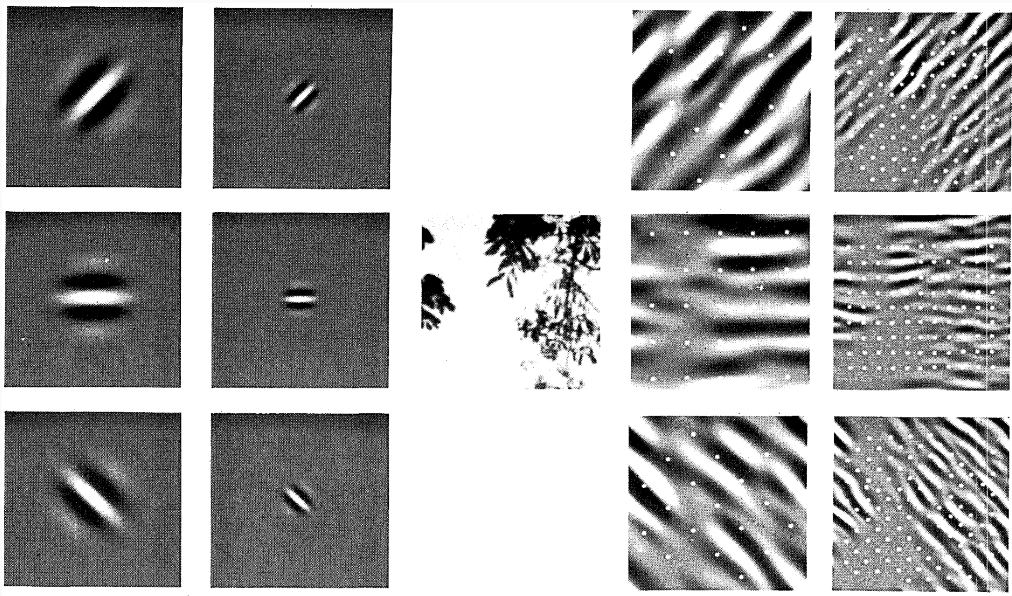

An example of coding with six different channels. (Left) Examples of the six types of sensor associated with each channel. (Right) Convolution of the image in (Middle) with the six sensors shown in (Left). The response of the individual sensors is determined by sampling these filtered images at a distance proportional to the size of the sensor (shown with dots). This diagram shows the response of only the even symmetric sensors.](../img/field-visual.png)


As it turns out, this relation even holds for the features computed by deeper layers of networks trained on image classification tasks, as demonstrated in, for example, `Kuzovkin.Vicente.Petton.ea.2018`. Suffice it to say, convolutions have proven to be an incredibly powerful tool for computer vision, both in biology and in code. As such, it is not surprising (in hindsight) that they heralded the recent success in deep learning.

## 7.3. Padding and Stride

Recall the example of a convolution in :numref:`fig_correlation`.
The input had both a height and width of 3
and the convolution kernel had both a height and width of 2,
yielding an output representation with dimension $2\times2$.
Assuming that the input shape is $n_\textrm{h}\times n_\textrm{w}$
and the convolution kernel shape is $k_\textrm{h}\times k_\textrm{w}$,
the output shape will be $(n_\textrm{h}-k_\textrm{h}+1) \times (n_\textrm{w}-k_\textrm{w}+1)$:
we can only shift the convolution kernel so far until it runs out
of pixels to apply the convolution to.

In the following we will explore a number of techniques,
including padding and strided convolutions,
that offer more control over the size of the output.
As motivation, note that since kernels generally
have width and height greater than $1$,
after applying many successive convolutions,
we tend to wind up with outputs that are
considerably smaller than our input.
If we start with a $240 \times 240$ pixel image,
ten layers of $5 \times 5$ convolutions
reduce the image to $200 \times 200$ pixels,
slicing off $30 \%$ of the image and with it
obliterating any interesting information
on the boundaries of the original image.
*Padding* is the most popular tool for handling this issue.
In other cases, we may want to reduce the dimensionality drastically,
e.g., if we find the original input resolution to be unwieldy.
*Strided convolutions* are a popular technique that can help in these instances.

In [13]:
import torch
from torch import nn

### 7.3.1. Padding

As described above, one tricky issue when applying convolutional layers
is that we tend to lose pixels on the perimeter of our image. Consider :numref:`img_conv_reuse` that depicts the pixel utilization as a function of the convolution kernel size and the position within the image. The pixels in the corners are hardly used at all.

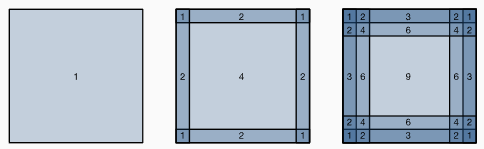


Since we typically use small kernels,
for any given convolution
we might only lose a few pixels
but this can add up as we apply
many successive convolutional layers.
One straightforward solution to this problem
is to add extra pixels of filler around the boundary of our input image,
thus increasing the effective size of the image.
Typically, we set the values of the extra pixels to zero.
In :numref:`img_conv_pad`, we pad a $3 \times 3$ input,
increasing its size to $5 \times 5$.
The corresponding output then increases to a $4 \times 4$ matrix.
The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times0+0\times1+0\times2+0\times3=0$.

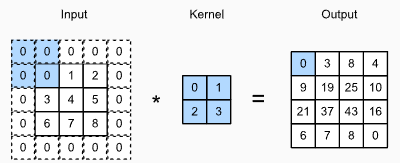

In general, if we add a total of $p_\textrm{h}$ rows of padding
(roughly half on top and half on bottom)
and a total of $p_\textrm{w}$ columns of padding
(roughly half on the left and half on the right),
the output shape will be

$$(n_\textrm{h}-k_\textrm{h}+p_\textrm{h}+1)\times(n_\textrm{w}-k_\textrm{w}+p_\textrm{w}+1).$$

This means that the height and width of the output
will increase by $p_\textrm{h}$ and $p_\textrm{w}$, respectively.

In many cases, we will want to set $p_\textrm{h}=k_\textrm{h}-1$ and $p_\textrm{w}=k_\textrm{w}-1$
to give the input and output the same height and width.
This will make it easier to predict the output shape of each layer
when constructing the network.
Assuming that $k_\textrm{h}$ is odd here,
we will pad $p_\textrm{h}/2$ rows on both sides of the height.
If $k_\textrm{h}$ is even, one possibility is to
pad $\lceil p_\textrm{h}/2\rceil$ rows on the top of the input
and $\lfloor p_\textrm{h}/2\rfloor$ rows on the bottom.
We will pad both sides of the width in the same way.

CNNs commonly use convolution kernels
with odd height and width values, such as 1, 3, 5, or 7.
Choosing odd kernel sizes has the benefit
that we can preserve the dimensionality
while padding with the same number of rows on top and bottom,
and the same number of columns on left and right.

Moreover, this practice of using odd kernels
and padding to precisely preserve dimensionality
offers a clerical benefit.
For any two-dimensional tensor `X`,
when the kernel's size is odd
and the number of padding rows and columns
on all sides are the same,
thereby producing an output with the same height and width as the input,
we know that the output `Y[i, j]` is calculated
by cross-correlation of the input and convolution kernel
with the window centered on `X[i, j]`.

In the following example, we create a two-dimensional convolutional layer
with a height and width of 3
and (**apply 1 pixel of padding on all sides.**)
Given an input with a height and width of 8,
we find that the height and width of the output is also 8.

In [14]:
# We define a helper function to calculate convolutions. It initializes the
# convolutional layer weights and performs corresponding dimensionality
# elevations and reductions on the input and output
def comp_conv2d(conv2d, X):
    # (1, 1) indicates that batch size and the number of channels are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Strip the first two dimensions: examples and channels
    return Y.reshape(Y.shape[2:])

# 1 row and column is padded on either side, so a total of 2 rows or columns
# are added
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

When the height and width of the convolution kernel are different, we can make the output and input have the same height and width by setting different padding numbers for height and width.

In [15]:
# We use a convolution kernel with height 5 and width 3. The padding on either
# side of the height and width are 2 and 1, respectively
conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

### 7.3.2. Stride

When computing the cross-correlation,
we start with the convolution window
at the upper-left corner of the input tensor,
and then slide it over all locations both down and to the right.
In the previous examples, we defaulted to sliding one element at a time.
However, sometimes, either for computational efficiency
or because we wish to downsample,
we move our window more than one element at a time,
skipping the intermediate locations. This is particularly useful if the convolution
kernel is large since it captures a large area of the underlying image.

We refer to the number of rows and columns traversed per slide as *stride*.
So far, we have used strides of 1, both for height and width.
Sometimes, we may want to use a larger stride.
:numref:`img_conv_stride` shows a two-dimensional cross-correlation operation
with a stride of 3 vertically and 2 horizontally.
The shaded portions are the output elements as well as the input and kernel tensor elements used for the output computation: $0\times0+0\times1+1\times2+2\times3=8$, $0\times0+6\times1+0\times2+0\times3=6$.
We can see that when the second element of the first column is generated,
the convolution window slides down three rows.
The convolution window slides two columns to the right
when the second element of the first row is generated.
When the convolution window continues to slide two columns to the right on the input,
there is no output because the input element cannot fill the window
(unless we add another column of padding).

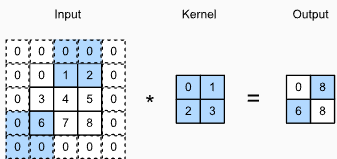

In general, when the stride for the height is $s_\textrm{h}$
and the stride for the width is $s_\textrm{w}$, the output shape is

$$\lfloor(n_\textrm{h}-k_\textrm{h}+p_\textrm{h}+s_\textrm{h})/s_\textrm{h}\rfloor \times \lfloor(n_\textrm{w}-k_\textrm{w}+p_\textrm{w}+s_\textrm{w})/s_\textrm{w}\rfloor.$$

If we set $p_\textrm{h}=k_\textrm{h}-1$ and $p_\textrm{w}=k_\textrm{w}-1$,
then the output shape can be simplified to
$\lfloor(n_\textrm{h}+s_\textrm{h}-1)/s_\textrm{h}\rfloor \times \lfloor(n_\textrm{w}+s_\textrm{w}-1)/s_\textrm{w}\rfloor$.
Going a step further, if the input height and width
are divisible by the strides on the height and width,
then the output shape will be $(n_\textrm{h}/s_\textrm{h}) \times (n_\textrm{w}/s_\textrm{w})$.

Below, we [**set the strides on both the height and width to 2**],
thus halving the input height and width.

In [16]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

Let’s look at a slightly more complicated example.

In [17]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

## 7.4. Multiple Input and Multiple Output Channels

While we described the multiple channels
that comprise each image (e.g., color images have the standard RGB channels
to indicate the amount of red, green and blue) and convolutional layers for multiple channels in :numref:`subsec_why-conv-channels`,
until now, we simplified all of our numerical examples
by working with just a single input and a single output channel.
This allowed us to think of our inputs, convolution kernels,
and outputs each as two-dimensional tensors.

When we add channels into the mix,
our inputs and hidden representations
both become three-dimensional tensors.
For example, each RGB input image has shape $3\times h\times w$.
We refer to this axis, with a size of 3, as the *channel* dimension. The notion of
channels is as old as CNNs themselves: for instance LeNet-5 :cite:`LeCun.Jackel.Bottou.ea.1995` uses them.
In this section, we will take a deeper look
at convolution kernels with multiple input and multiple output channels.

In [18]:
import torch
from d2l import torch as d2l

### 7.4.1. Multiple Input Channels

When the input data contains multiple channels,
we need to construct a convolution kernel
with the same number of input channels as the input data,
so that it can perform cross-correlation with the input data.
Assuming that the number of channels for the input data is $c_\textrm{i}$,
the number of input channels of the convolution kernel also needs to be $c_\textrm{i}$. If our convolution kernel's window shape is $k_\textrm{h}\times k_\textrm{w}$,
then, when $c_\textrm{i}=1$, we can think of our convolution kernel
as just a two-dimensional tensor of shape $k_\textrm{h}\times k_\textrm{w}$.

However, when $c_\textrm{i}>1$, we need a kernel
that contains a tensor of shape $k_\textrm{h}\times k_\textrm{w}$ for *every* input channel. Concatenating these $c_\textrm{i}$ tensors together
yields a convolution kernel of shape $c_\textrm{i}\times k_\textrm{h}\times k_\textrm{w}$.
Since the input and convolution kernel each have $c_\textrm{i}$ channels,
we can perform a cross-correlation operation
on the two-dimensional tensor of the input
and the two-dimensional tensor of the convolution kernel
for each channel, adding the $c_\textrm{i}$ results together
(summing over the channels)
to yield a two-dimensional tensor.
This is the result of a two-dimensional cross-correlation
between a multi-channel input and
a multi-input-channel convolution kernel.

:numref:`fig_conv_multi_in` provides an example
of a two-dimensional cross-correlation with two input channels.
The shaded portions are the first output element
as well as the input and kernel tensor elements used for the output computation:
$(1\times1+2\times2+4\times3+5\times4)+(0\times0+1\times1+3\times2+4\times3)=56$.

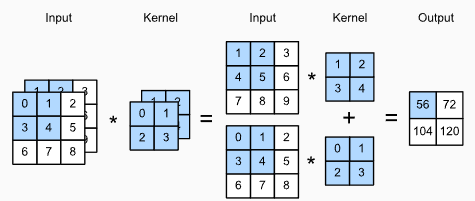

To make sure we really understand what is going on here, we can implement cross-correlation operations with multiple input channels ourselves. Notice that all we are doing is performing a cross-correlation operation per channel and then adding up the results.

In [19]:
def corr2d_multi_in(X, K):
    # Iterate through the 0th dimension (channel) of K first, then add them up
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

We can construct the input tensor X and the kernel tensor K corresponding to the values in Fig. 7.4.1 to validate the output of the cross-correlation operation.

In [20]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

### 7.4.2. Multiple Output Channels

Regardless of the number of input channels,
so far we always ended up with one output channel.
However, as we discussed in :numref:`subsec_why-conv-channels`,
it turns out to be essential to have multiple channels at each layer.
In the most popular neural network architectures,
we actually increase the channel dimension
as we go deeper in the neural network,
typically downsampling to trade off spatial resolution
for greater *channel depth*.
Intuitively, you could think of each channel
as responding to a different set of features.
The reality is a bit more complicated than this. A naive interpretation would suggest
that representations are learned independently per pixel or per channel.
Instead, channels are optimized to be jointly useful.
This means that rather than mapping a single channel to an edge detector, it may simply mean
that some direction in channel space corresponds to detecting edges.

Denote by $c_\textrm{i}$ and $c_\textrm{o}$ the number
of input and output channels, respectively,
and by $k_\textrm{h}$ and $k_\textrm{w}$ the height and width of the kernel.
To get an output with multiple channels,
we can create a kernel tensor
of shape $c_\textrm{i}\times k_\textrm{h}\times k_\textrm{w}$
for *every* output channel.
We concatenate them on the output channel dimension,
so that the shape of the convolution kernel
is $c_\textrm{o}\times c_\textrm{i}\times k_\textrm{h}\times k_\textrm{w}$.
In cross-correlation operations,
the result on each output channel is calculated
from the convolution kernel corresponding to that output channel
and takes input from all channels in the input tensor.

We implement a cross-correlation function
to [**calculate the output of multiple channels**] as shown below.

In [21]:
def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of K, and each time, perform
    # cross-correlation operations with input X. All of the results are
    # stacked together
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

We construct a trivial convolution kernel with three output channels by concatenating the kernel tensor for K with K+1 and K+2.

In [22]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

Below, we perform cross-correlation operations on the input tensor X with the kernel tensor K. Now the output contains three channels. The result of the first channel is consistent with the result of the previous input tensor X and the multi-input channel, single-output channel kernel.

In [23]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

### 7.4.3 $1\times 1$ Convolutional Layer

At first, a [**$1 \times 1$ convolution**], i.e., $k_\textrm{h} = k_\textrm{w} = 1$,
does not seem to make much sense.
After all, a convolution correlates adjacent pixels.
A $1 \times 1$ convolution obviously does not.
Nonetheless, they are popular operations that are sometimes included
in the designs of complex deep networks :cite:`Lin.Chen.Yan.2013,Szegedy.Ioffe.Vanhoucke.ea.2017`.
Let's see in some detail what it actually does.

Because the minimum window is used,
the $1\times 1$ convolution loses the ability
of larger convolutional layers
to recognize patterns consisting of interactions
among adjacent elements in the height and width dimensions.
The only computation of the $1\times 1$ convolution occurs
on the channel dimension.

:numref:`fig_conv_1x1` shows the cross-correlation computation
using the $1\times 1$ convolution kernel
with 3 input channels and 2 output channels.
Note that the inputs and outputs have the same height and width.
Each element in the output is derived
from a linear combination of elements *at the same position*
in the input image.
You could think of the $1\times 1$ convolutional layer
as constituting a fully connected layer applied at every single pixel location
to transform the $c_\textrm{i}$ corresponding input values into $c_\textrm{o}$ output values.
Because this is still a convolutional layer,
the weights are tied across pixel location.
Thus the $1\times 1$ convolutional layer requires $c_\textrm{o}\times c_\textrm{i}$ weights
(plus the bias). Also note that convolutional layers are typically followed
by nonlinearities. This ensures that $1 \times 1$ convolutions cannot simply be
folded into other convolutions.

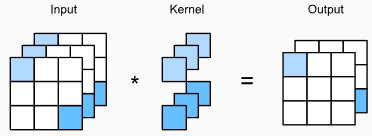

Let's check whether this works in practice:
we implement a $1 \times 1$ convolution
using a fully connected layer.
The only thing is that we need to make some adjustments
to the data shape before and after the matrix multiplication.

In [24]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # Matrix multiplication in the fully connected layer
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

When performing $1\times 1$ convolutions,
the above function is equivalent to the previously implemented cross-correlation function `corr2d_multi_in_out`.
Let's check this with some sample data.

In [25]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

## 7.5. Pooling

In many cases our ultimate task asks some global question about the image, e.g., does it contain a cat? Consequently, the units of our final layer should be sensitive to the entire input. By gradually aggregating information, yielding coarser and coarser maps, we accomplish this goal of ultimately learning a global representation, while keeping all of the advantages of convolutional layers at the intermediate layers of processing. The deeper we go in the network, the larger the receptive field (relative to the input) to which each hidden node is sensitive. Reducing spatial resolution accelerates this process, since the convolution kernels cover a larger effective area.

Moreover, when detecting lower-level features, such as edges (as discussed in Section 7.2), we often want our representations to be somewhat invariant to translation. For instance, if we take the image X with a sharp delineation between black and white and shift the whole image by one pixel to the right, i.e., Z[i, j] = X[i, j + 1], then the output for the new image Z might be vastly different. The edge will have shifted by one pixel. In reality, objects hardly ever occur exactly at the same place. In fact, even with a tripod and a stationary object, vibration of the camera due to the movement of the shutter might shift everything by a pixel or so (high-end cameras are loaded with special features to address this problem).

This section introduces pooling layers, which serve the dual purposes of mitigating the sensitivity of convolutional layers to location and of spatially downsampling representations.

In [26]:
import torch
from torch import nn
from d2l import torch as d2l

### 7.5.1. Maximum Pooling and Average Pooling

Like convolutional layers, *pooling* operators
consist of a fixed-shape window that is slid over
all regions in the input according to its stride,
computing a single output for each location traversed
by the fixed-shape window (sometimes known as the *pooling window*).
However, unlike the cross-correlation computation
of the inputs and kernels in the convolutional layer,
the pooling layer contains no parameters (there is no *kernel*).
Instead, pooling operators are deterministic,
typically calculating either the maximum or the average value
of the elements in the pooling window.
These operations are called *maximum pooling* (*max-pooling* for short)
and *average pooling*, respectively.

*Average pooling* is essentially as old as CNNs. The idea is akin to
downsampling an image. Rather than just taking the value of every second (or third)
pixel for the lower resolution image, we can average over adjacent pixels to obtain
an image with better signal-to-noise ratio since we are combining the information
from multiple adjacent pixels. *Max-pooling* was introduced in
:citet:`Riesenhuber.Poggio.1999` in the context of cognitive neuroscience to describe
how information aggregation might be aggregated hierarchically for the purpose
of object recognition; there already was an earlier version in speech recognition :cite:`Yamaguchi.Sakamoto.Akabane.ea.1990`. In almost all cases, max-pooling, as it is also referred to,
is preferable to average pooling.

In both cases, as with the cross-correlation operator,
we can think of the pooling window
as starting from the upper-left of the input tensor
and sliding across it from left to right and top to bottom.
At each location that the pooling window hits,
it computes the maximum or average
value of the input subtensor in the window,
depending on whether max or average pooling is employed.


![Max-pooling with a pooling window shape of $2\times 2$. The shaded portions are the first output element as well as the input tensor elements used for the output computation: $\max(0, 1, 3, 4)=4$.](http://d2l.ai/_images/pooling.svg)

The output tensor in :numref:`fig_pooling`  has a height of 2 and a width of 2.
The four elements are derived from the maximum value in each pooling window:

$$
\max(0, 1, 3, 4)=4,\\
\max(1, 2, 4, 5)=5,\\
\max(3, 4, 6, 7)=7,\\
\max(4, 5, 7, 8)=8.\\
$$

More generally, we can define a $p \times q$ pooling layer by aggregating over
a region of said size. Returning to the problem of edge detection,
we use the output of the convolutional layer
as input for $2\times 2$ max-pooling.
Denote by `X` the input of the convolutional layer input and `Y` the pooling layer output.
Regardless of whether or not the values of `X[i, j]`, `X[i, j + 1]`,
`X[i+1, j]` and `X[i+1, j + 1]` are different,
the pooling layer always outputs `Y[i, j] = 1`.
That is to say, using the $2\times 2$ max-pooling layer,
we can still detect if the pattern recognized by the convolutional layer
moves no more than one element in height or width.

In the code below, we (**implement the forward propagation
of the pooling layer**) in the `pool2d` function.
This function is similar to the `corr2d` function
in :numref:`sec_conv_layer`.
However, no kernel is needed, computing the output
as either the maximum or the average of each region in the input.


In [27]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

We can construct the input tensor X in Fig. 7.5.1 to validate the output of the two-dimensional max-pooling layer.

In [28]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

Also, we can experiment with the average pooling layer.

In [29]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

### 7.5.2. Padding and Stride

As with convolutional layers, pooling layers change the output shape. And as before, we can adjust the operation to achieve a desired output shape by padding the input and adjusting the stride. We can demonstrate the use of padding and strides in pooling layers via the built-in two-dimensional max-pooling layer from the deep learning framework. We first construct an input tensor X whose shape has four dimensions, where the number of examples (batch size) and number of channels are both 1.

In [30]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

Since pooling aggregates information from an area, deep learning frameworks default to matching pooling window sizes and stride. For instance, if we use a pooling window of shape (3, 3) we get a stride shape of (3, 3) by default.

In [31]:
pool2d = nn.MaxPool2d(3)
# Pooling has no model parameters, hence it needs no initialization
pool2d(X)

tensor([[[[10.]]]])

Needless to say, the stride and padding can be manually specified to override framework defaults if required.

In [32]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

Of course, we can specify an arbitrary rectangular pooling window with arbitrary height and width respectively, as the example below shows.

In [33]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

### 7.5.3. Multiple Channels

When processing multi-channel input data, the pooling layer pools each input channel separately, rather than summing the inputs up over channels as in a convolutional layer. This means that the number of output channels for the pooling layer is the same as the number of input channels. Below, we will concatenate tensors X and X + 1 on the channel dimension to construct an input with two channels.

In [34]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

As we can see, the number of output channels is still two after pooling.

In [35]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## 7.6. Convolutional Neural Networks (LeNet)

We now have all the ingredients required to assemble
a fully-functional CNN.
In our earlier encounter with image data, we applied
a linear model with softmax regression (:numref:`sec_softmax_scratch`)
and an MLP (:numref:`sec_mlp-implementation`)
to pictures of clothing in the Fashion-MNIST dataset.
To make such data amenable we first flattened each image from a $28\times28$ matrix
into a fixed-length $784$-dimensional vector,
and thereafter processed them in fully connected layers.
Now that we have a handle on convolutional layers,
we can retain the spatial structure in our images.
As an additional benefit of replacing fully connected layers with convolutional layers,
we will enjoy more parsimonious models that require far fewer parameters.

In this section, we will introduce *LeNet*,
among the first published CNNs
to capture wide attention for its performance on computer vision tasks.
The model was introduced by (and named for) Yann LeCun,
then a researcher at AT&T Bell Labs,
for the purpose of recognizing handwritten digits in images :cite:`LeCun.Bottou.Bengio.ea.1998`.
This work represented the culmination
of a decade of research developing the technology;
LeCun's team published the first study to successfully
train CNNs via backpropagation :cite:`LeCun.Boser.Denker.ea.1989`.

At the time LeNet achieved outstanding results
matching the performance of support vector machines,
then a dominant approach in supervised learning, achieving an error rate of less than 1% per digit.
LeNet was eventually adapted to recognize digits
for processing deposits in ATM machines.
To this day, some ATMs still run the code
that Yann LeCun and his colleague Leon Bottou wrote in the 1990s!


In [36]:
import torch
from torch import nn
from d2l import torch as d2l

### 7.6.1. LeNet

At a high level, (**LeNet (LeNet-5) consists of two parts:
(i) a convolutional encoder consisting of two convolutional layers; and
(ii) a dense block consisting of three fully connected layers**).
The architecture is summarized in :numref:`img_lenet`.

![Data flow in LeNet. The input is a handwritten digit, the output is a probability over 10 possible outcomes.](http://d2l.ai/_images/lenet.svg)

The basic units in each convolutional block
are a convolutional layer, a sigmoid activation function,
and a subsequent average pooling operation.
Note that while ReLUs and max-pooling work better,
they had not yet been discovered.
Each convolutional layer uses a $5\times 5$ kernel
and a sigmoid activation function.
These layers map spatially arranged inputs
to a number of two-dimensional feature maps, typically
increasing the number of channels.
The first convolutional layer has 6 output channels,
while the second has 16.
Each $2\times2$ pooling operation (stride 2)
reduces dimensionality by a factor of $4$ via spatial downsampling.
The convolutional block emits an output with shape given by
(batch size, number of channel, height, width).

In order to pass output from the convolutional block
to the dense block,
we must flatten each example in the minibatch.
In other words, we take this four-dimensional input and transform it
into the two-dimensional input expected by fully connected layers:
as a reminder, the two-dimensional representation that we desire uses the first dimension to index examples in the minibatch
and the second to give the flat vector representation of each example.
LeNet's dense block has three fully connected layers,
with 120, 84, and 10 outputs, respectively.
Because we are still performing classification,
the 10-dimensional output layer corresponds
to the number of possible output classes.

While getting to the point where you truly understand
what is going on inside LeNet may have taken a bit of work,
we hope that the following code snippet will convince you
that implementing such models with modern deep learning frameworks
is remarkably simple.
We need only to instantiate a `Sequential` block
and chain together the appropriate layers,
using Xavier initialization as
introduced in :numref:`subsec_xavier`.

In [37]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

We have taken some liberty in the reproduction of LeNet insofar as we have replaced the Gaussian activation layer by
a softmax layer. This greatly simplifies the implementation, not least due to the
fact that the Gaussian decoder is rarely used nowadays. Other than that, this network matches
the original LeNet-5 architecture.


Let's see what happens inside the network. By passing a
single-channel (black and white)
$28 \times 28$ image through the network
and printing the output shape at each layer,
we can [**inspect the model**] to ensure
that its operations line up with
what we expect from :numref:`img_lenet_vert`.


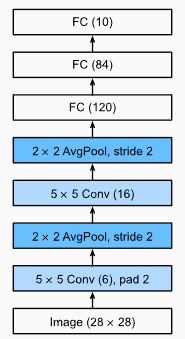

In [38]:
@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


### 7.6.2. Training

Now that we have implemented the model, let’s run an experiment to see how the LeNet-5 model fares on Fashion-MNIST.

While CNNs have fewer parameters, they can still be more expensive to compute than similarly deep MLPs because each parameter participates in many more multiplications. If you have access to a GPU, this might be a good time to put it into action to speed up training. Note that the d2l.Trainer class takes care of all details. By default, it initializes the model parameters on the available devices. Just as with MLPs, our loss function is cross-entropy, and we minimize it via minibatch stochastic gradient descent.

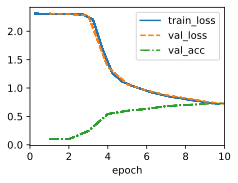

In [39]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

# Discussions & Exercises

### 7.1. Discussion

**Invariance:** Translation invariance allows the system to detect objects irrespective of their exact location.

**Locality:** Early layers of CNNs focus on local regions of the image.

**Convolution:** By using a convolutional operation, the number of parameters can be drastically reduced, making the network more efficient.

**Channels:** Images are typically represented with multiple channels (e.g., RGB), and CNNs account for this by having multiple input and hidden channels (feature maps).

CNNs balance reducing parameters while maintaining the ability to capture important patterns in data by leveraging inductive biases like translation invariance and locality, leading to practical models that generalize well.

- Importance of Convolutions in Image Processing: The shift from MLPs to CNNs is crucial for handling large-scale perceptual data, especially high-resolution images. Understanding how convolutions reduce parameters and make image processing feasible is central to modern AI applications.
- Translation Invariance: How CNNs handle translation invariance is an important topic to explore further. How does this property make CNNs so effective for tasks like image classification and object detection?
- Channels and Feature Maps: The concept of channels (RGB) and their evolution into feature maps through convolutional layers can be discussed in more depth. How do CNNs learn to detect different features, like edges, textures, and complex objects through multiple layers?
- Efficient Model Design: Further exploration of how CNNs maintain efficiency by using fewer parameters and focusing on locality might be important in areas like hardware optimization and edge computing.

### 7.1 Exercises & My Own Experiments

In [45]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

# MNIST 데이터셋을 불러오고 전처리합니다.
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# 데이터를 CNN에 맞게 (28, 28, 1) 모양으로 reshape하고 normalize(0~1 범위로 변경)합니다.
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1)).astype('float32') / 255

# 각 이미지의 라벨을 one-hot encoding 합니다.
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)


In [46]:
model = models.Sequential()

# 첫 번째 합성곱 레이어: 필터 수 32, 커널 크기 (3, 3), 활성화 함수 ReLU
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# 두 번째 합성곱 레이어: 필터 수 64, 커널 크기 (3, 3), 활성화 함수 ReLU
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 세 번째 합성곱 레이어: 필터 수 64, 커널 크기 (3, 3), 활성화 함수 ReLU
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# 완전 연결 층을 위해 1차원으로 펼치기
model.add(layers.Flatten())

# 완전 연결 층 (Dense Layer): 뉴런 수 64, 활성화 함수 ReLU
model.add(layers.Dense(64, activation='relu'))

# 출력 레이어: 뉴런 수 10 (0~9 숫자 클래스), 활성화 함수 softmax
model.add(layers.Dense(10, activation='softmax'))

# 모델 요약 출력
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_images, train_labels, epochs=5,
                    validation_data=(test_images, test_labels))


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 67s 34ms/step - accuracy: 0.8878 - loss: 0.3543 - val_accuracy: 0.9740 - val_loss: 0.0847
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 94s 41ms/step - accuracy: 0.9850 - loss: 0.0487 - val_accuracy: 0.9876 - val_loss: 0.0378
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 72s 35ms/step - accuracy: 0.9898 - loss: 0.0324 - val_accuracy: 0.9924 - val_loss: 0.0259
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 36ms/step - accuracy: 0.9926 - loss: 0.0228 - val_accuracy: 0.9903 - val_loss: 0.0321
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 36ms/step - accuracy: 0.9938 - loss: 0.0198 - val_accuracy: 0.9892 - val_loss: 0.0388


313/313 - 3s - 9ms/step - accuracy: 0.9892 - loss: 0.0388
테스트 정확도: 0.9891999959945679


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54984 (\N{HANGUL SYLLABLE HUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47144 (\N{HANGUL SYLLABLE RYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48143 (\N{HANGUL SYLLABLE MIC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-pack

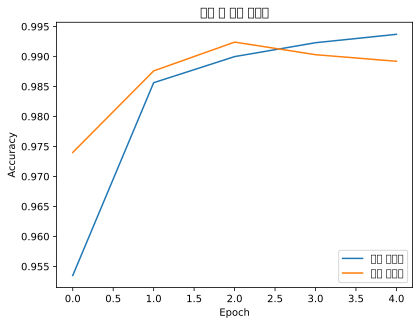

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


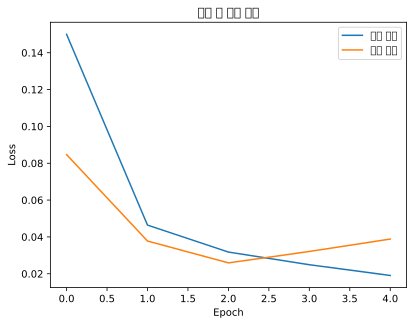

In [48]:
# 테스트 데이터로 모델 평가
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"테스트 정확도: {test_acc}")

# 훈련 및 검증 과정에서의 정확도와 손실 그래프 시각화
plt.plot(history.history['accuracy'], label='훈련 정확도')
plt.plot(history.history['val_accuracy'], label='검증 정확도')
plt.title('훈련 및 검증 정확도')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='훈련 손실')
plt.plot(history.history['val_loss'], label='검증 손실')
plt.title('훈련 및 검증 손실')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


### 7.2. Discussion

**Edge Detection:**
- Concept: Detects edges in images by identifying changes in pixel intensity.
- Kernel: A simple kernel like [1, -1] detects horizontal edges by subtracting adjacent pixels. This works by calculating the difference between neighboring pixels, outputting non-zero values where intensity changes (edges).
- Horizontal and Vertical Edge Detection: Applying the kernel detects horizontal edges, but applying it to the transposed image does not detect vertical edges. Specific kernels are needed for different edge orientations.
- Practical Use: Edge detection is a basic step in image processing and can be used in object recognition, feature extraction, and computer vision tasks.

**Learning Kernels:**
- Automatic Kernel Learning: Instead of manually defining filters like [1, -1], CNNs learn optimal kernels through training, adjusting the kernel weights to minimize loss during backpropagation.
- Example: In edge detection, the learned kernel might resemble [1, -1], but as we increase the kernel size and layers, the network can detect more complex features automatically.

**Receptive Field:**
- Definition: The receptive field refers to the portion of the input image that contributes to a single output value in a convolutional layer.
- Importance: As the network deepens, the receptive field increases, allowing the network to detect broader and more global features of the input image.

### 7.2. Exercises & My Own Experiments

Input image:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
        [1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
        [1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
        [1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
        [1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
        [1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

Edge detection result:
tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


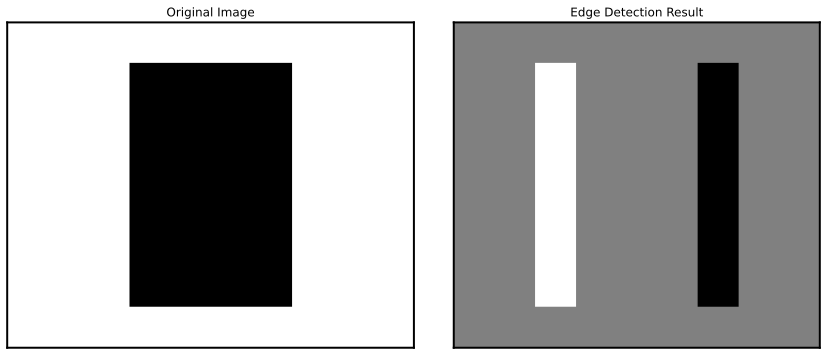

epoch 2, loss 2.079
epoch 4, loss 20.956
epoch 6, loss 7727.283
epoch 8, loss 2896238.000
epoch 10, loss 1085537408.000

Learned kernel:
tensor([[-10804.3555, -10806.3428]])


In [53]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def corr2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

# Create input tensor with padding
X = torch.ones((8, 10))
X[1:-1, 3:-3] = 0  # The main image content is now 6x4
print("Input image:")
print(X)

# Create kernel for edge detection
K = torch.tensor([[1.0, -1.0]])

# Perform edge detection
Y = corr2d(X, K)
print("\nEdge detection result:")
print(Y)

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Function to add a border to the plot
def add_border(ax, image):
    ax.imshow(image, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(2)

add_border(ax1, X.numpy())
ax1.set_title('Original Image')

add_border(ax2, Y.numpy())
ax2.set_title('Edge Detection Result')

plt.tight_layout()
plt.show()

# Learning a kernel
# Convert X and Y to the shape expected by nn.Conv2d
X = X.reshape((1, 1, 8, 10))
Y = Y.reshape((1, 1, 8, 9))

# Create a convolutional layer
conv2d = torch.nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)

# Training loop
lr = 3e-2
for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    conv2d.weight.grad.zero_()
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

print("\nLearned kernel:")
print(conv2d.weight.data.reshape((1, 2)))

### 7.3. Discussion

*Padding* helps preserve the spatial dimensions of the input by adding extra pixels (usually zero) around the boundary. Without padding, the image shrinks after every convolution layer, especially when using larger kernels. Padding ensures that the output height and width are the same as the input, particularly when using odd-sized kernels, which are common in practice.

*Stride* refers to the step size of the convolution window as it slides over the input. A larger stride reduces the output size because fewer positions are sampled. This is useful for downsampling the input, either for computational efficiency or when reducing the resolution of the input data. Setting stride and padding appropriately helps control the size of the feature map while keeping important features intact.

- With padding:



$$ \text{Output shape} = (n_h - k_h + p_h + 1) \times (n_w - k_w + p_w + 1) $$

- With stride:

$$ \text{Output shape} = \left\lfloor\frac{n_h - k_h + p_h + s_h}{s_h}\right\rfloor \times \left\lfloor\frac{n_w - k_w + p_w + s_w}{s_w}\right\rfloor $$

1. **Padding and Stride in Convolutions:**
How they directly influence output dimensions and are essential in designing CNN architectures, particularly for applications in image processing, where preserving the size of the feature map or reducing it in a controlled way is important.

2. **Effect of Kernel Size on Output:**
Larger kernels can quickly reduce the size of the image representation, potentially losing important edge information, which emphasizes the need for padding. Conversely, strided convolutions allow for downsampling, but they reduce the resolution of the output feature maps.

3. **Balancing Computation and Output Size:**
A significant challenge is maintaining a balance between computational efficiency and retaining useful information. Using larger strides or kernels can speed up computations but risks losing important spatial information.

### 7.3. Exercises & My Own Experiments

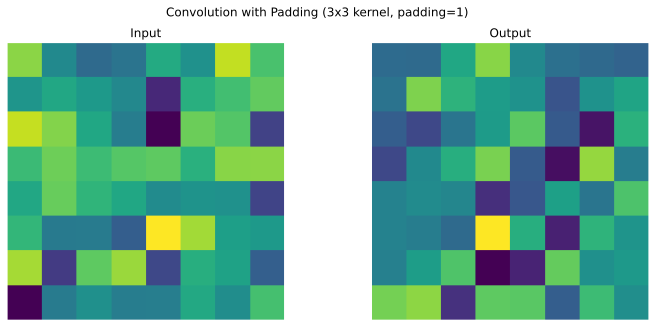

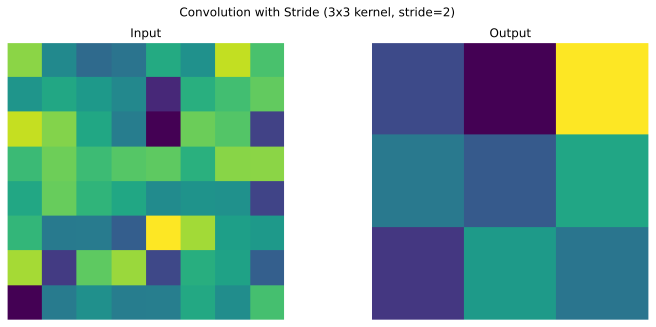

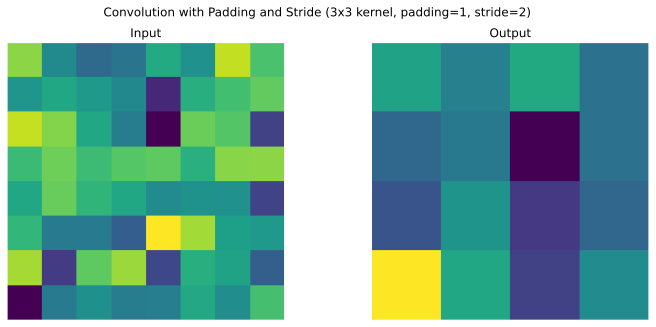

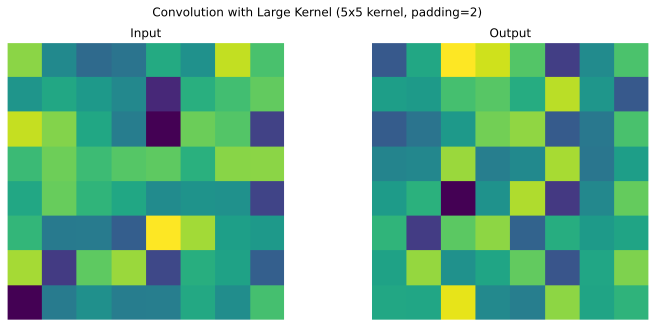

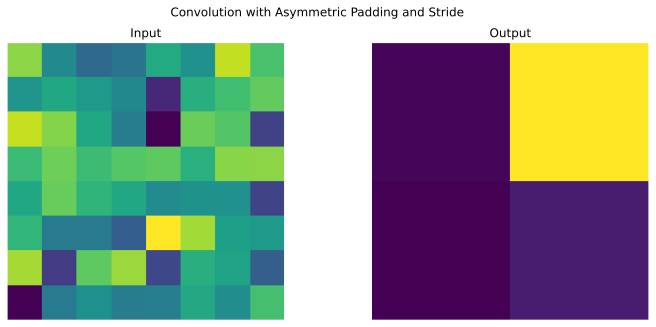

Experiment complete. Check the visualizations to understand the effects of padding and stride.


In [54]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def visualize_conv2d(input_tensor, conv_layer, title):
    # Apply convolution
    output = conv_layer(input_tensor)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot input
    ax1.imshow(input_tensor.squeeze().detach().numpy(), cmap='viridis')
    ax1.set_title('Input')
    ax1.axis('off')

    # Plot output
    ax2.imshow(output.squeeze().detach().numpy(), cmap='viridis')
    ax2.set_title('Output')
    ax2.axis('off')

    plt.suptitle(title)
    plt.show()

# Create a sample input tensor
input_tensor = torch.randn(1, 1, 8, 8)

# Experiment 1: Padding
conv_pad = nn.Conv2d(1, 1, kernel_size=3, padding=1)
visualize_conv2d(input_tensor, conv_pad, "Convolution with Padding (3x3 kernel, padding=1)")

# Experiment 2: Stride
conv_stride = nn.Conv2d(1, 1, kernel_size=3, stride=2)
visualize_conv2d(input_tensor, conv_stride, "Convolution with Stride (3x3 kernel, stride=2)")

# Experiment 3: Combination of Padding and Stride
conv_pad_stride = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
visualize_conv2d(input_tensor, conv_pad_stride, "Convolution with Padding and Stride (3x3 kernel, padding=1, stride=2)")

# Experiment 4: Different kernel sizes
conv_large_kernel = nn.Conv2d(1, 1, kernel_size=5, padding=2)
visualize_conv2d(input_tensor, conv_large_kernel, "Convolution with Large Kernel (5x5 kernel, padding=2)")

# Experiment 5: Asymmetric padding and stride
conv_asymmetric = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
visualize_conv2d(input_tensor, conv_asymmetric, "Convolution with Asymmetric Padding and Stride")

print("Experiment complete. Check the visualizations to understand the effects of padding and stride.")

### 7.4. Discussion

1. **Importance of Multi-Channel Input/Output in CNNs:** Multi-channel input and output are essential for handling the complexity of modern neural networks, particularly in image processing tasks where each channel can represent different features or aspects of the image.

2. **Cross-Correlation with Multiple Channels:** The process of cross-correlation for multi-channel data is a key operation that enables deep learning models to extract richer feature representations from input data.

3. **Significance of $1 \times 1$ Convolutions:** Despite its simplicity, the $1 \times 1$ convolution plays a critical role in reducing the number of parameters and computational complexity in deep networks. It is also useful for manipulating the depth of feature maps.

### 7.4. Exercises & My Own Experiments

In [56]:
import torch
import torch.nn.functional as F

def corr2d_multi_in(X, K):
    return sum(F.conv2d(x.unsqueeze(0).unsqueeze(0), k.unsqueeze(0).unsqueeze(0)) for x, k in zip(X, K))

def corr2d_multi_in_out(X, K):
    return torch.stack([corr2d_multi_in(X, k) for k in K])

# 1. Multi-input channel convolution
print("1. Multi-input channel convolution")
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
                  [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]],
                  [[1.0, 2.0], [3.0, 4.0]]])

print("Input shape:", X.shape)
print("Kernel shape:", K.shape)
Y = corr2d_multi_in(X, K)
print("Output:")
print(Y)
print("Output shape:", Y.shape)

# 2. Multi-input, multi-output channel convolution
print("\n2. Multi-input, multi-output channel convolution")
K = torch.stack((K, K + 1, K + 2), 0)
print("New kernel shape:", K.shape)
Y = corr2d_multi_in_out(X, K)
print("Output:")
print(Y)
print("Output shape:", Y.shape)

# 3. 1x1 Convolution
print("\n3. 1x1 Convolution")
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)

print("1x1 Convolution output shape:", Y1.shape)
print("Regular convolution output shape:", Y2.shape)
print("Difference between outputs:", float(torch.abs(Y1 - Y2).sum()))

# 4. Using PyTorch's built-in Conv2d
print("\n4. Using PyTorch's built-in Conv2d")
conv2d = torch.nn.Conv2d(in_channels=3, out_channels=2, kernel_size=1)
Y3 = conv2d(X.unsqueeze(0)).squeeze(0)
print("PyTorch Conv2d output shape:", Y3.shape)
print("Difference between PyTorch and our implementation:",
      float(torch.abs(Y3 - Y1).sum()))

1. Multi-input channel convolution
Input shape: torch.Size([2, 3, 3])
Kernel shape: torch.Size([2, 2, 2])
Output:
tensor([[[[ 56.,  72.],
          [104., 120.]]]])
Output shape: torch.Size([1, 1, 2, 2])

2. Multi-input, multi-output channel convolution
New kernel shape: torch.Size([3, 2, 2, 2])
Output:
tensor([[[[[ 56.,  72.],
           [104., 120.]]]],



        [[[[ 76., 100.],
           [148., 172.]]]],



        [[[[ 96., 128.],
           [192., 224.]]]]])
Output shape: torch.Size([3, 1, 1, 2, 2])

3. 1x1 Convolution
1x1 Convolution output shape: torch.Size([2, 3, 3])
Regular convolution output shape: torch.Size([2, 1, 1, 3, 3])
Difference between outputs: 20.021825790405273

4. Using PyTorch's built-in Conv2d
PyTorch Conv2d output shape: torch.Size([2, 3, 3])
Difference between PyTorch and our implementation: 14.509613990783691


### 7.5. Discussion

1. **Max-Pooling vs. Average Pooling:** Max-pooling selects the maximum value within a window, while average pooling takes the average. Max-pooling is generally preferred for better performance in tasks like object recognition.
2. **Pooling Window:** The window is slid over the input tensor, and at each position, either the max or average value is computed. A common choice is a 2x2 window.
3. **Padding and Stride:** Just like in convolutional layers, padding and stride can be used in pooling layers to control the output shape. These can either be set to default values or customized as needed.
4. **Handling Multiple Channels:** For multi-channel inputs, each channel is pooled independently, which means the number of output channels remains the same as the input.


- Convolutional Neural Networks (CNNs): CNN architecture and its essential layers, including convolution and pooling layers, are central to understanding how computers recognize and process images.

- Importance of Pooling: Pooling layers reduce spatial resolution, making the network less sensitive to slight movements or transformations of the input image. This is crucial for tasks like object detection, where objects rarely appear in exactly the same place.

- Feature Translation Invariance: This concept ensures that the network can recognize objects even if they are shifted slightly, which is vital for making models robust to different inputs.

### 7.5. Exercises & My Own Experiments

Input tensor:
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])


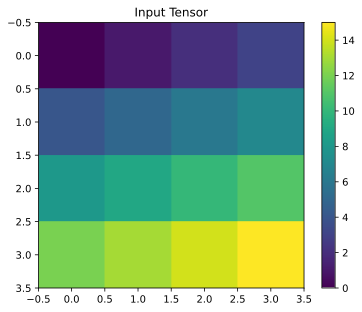


Custom max pooling result (2x2):
tensor([[ 5.,  6.,  7.],
        [ 9., 10., 11.],
        [13., 14., 15.]])


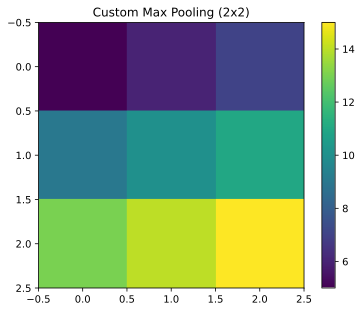


Custom average pooling result (2x2):
tensor([[ 2.5000,  3.5000,  4.5000],
        [ 6.5000,  7.5000,  8.5000],
        [10.5000, 11.5000, 12.5000]])


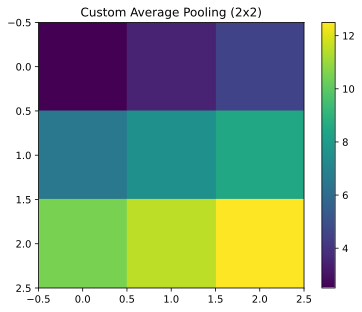


PyTorch built-in max pooling result (2x2):
tensor([[ 5.,  7.],
        [13., 15.]])


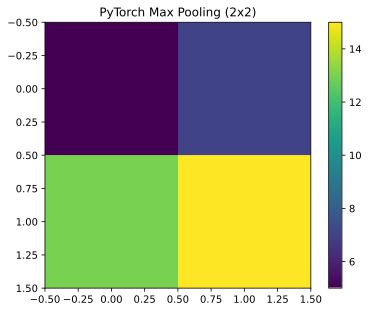


PyTorch built-in average pooling result (2x2):
tensor([[ 2.5000,  4.5000],
        [10.5000, 12.5000]])


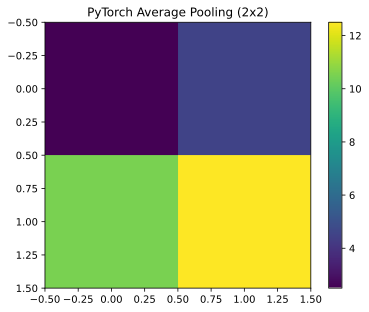


Custom max pooling result (3x3):
tensor([[10., 11.],
        [14., 15.]])


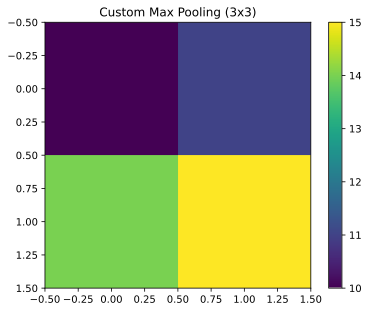


PyTorch built-in max pooling result (padding=1, stride=1):
tensor([[ 0.,  1.,  2.,  3.,  3.],
        [ 4.,  5.,  6.,  7.,  7.],
        [ 8.,  9., 10., 11., 11.],
        [12., 13., 14., 15., 15.],
        [12., 13., 14., 15., 15.]])


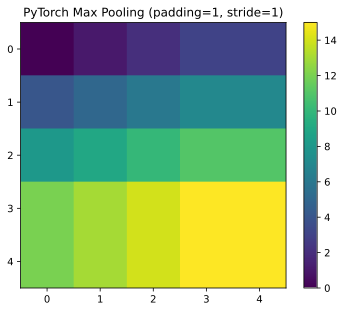

In [59]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def custom_pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

def visualize_tensor(tensor, title):
    plt.imshow(tensor.numpy(), cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Create input tensor
X = torch.tensor([[0.0, 1.0, 2.0, 3.0],
                  [4.0, 5.0, 6.0, 7.0],
                  [8.0, 9.0, 10.0, 11.0],
                  [12.0, 13.0, 14.0, 15.0]])

print("Input tensor:")
print(X)
visualize_tensor(X, "Input Tensor")

# Custom max pooling
custom_max_pooled = custom_pool2d(X, (2, 2), 'max')
print("\nCustom max pooling result (2x2):")
print(custom_max_pooled)
visualize_tensor(custom_max_pooled, "Custom Max Pooling (2x2)")

# Custom average pooling
custom_avg_pooled = custom_pool2d(X, (2, 2), 'avg')
print("\nCustom average pooling result (2x2):")
print(custom_avg_pooled)
visualize_tensor(custom_avg_pooled, "Custom Average Pooling (2x2)")

# PyTorch built-in max pooling
max_pool = nn.MaxPool2d(2)
torch_max_pooled = max_pool(X.unsqueeze(0).unsqueeze(0)).squeeze()
print("\nPyTorch built-in max pooling result (2x2):")
print(torch_max_pooled)
visualize_tensor(torch_max_pooled, "PyTorch Max Pooling (2x2)")

# PyTorch built-in average pooling
avg_pool = nn.AvgPool2d(2)
torch_avg_pooled = avg_pool(X.unsqueeze(0).unsqueeze(0)).squeeze()
print("\nPyTorch built-in average pooling result (2x2):")
print(torch_avg_pooled)
visualize_tensor(torch_avg_pooled, "PyTorch Average Pooling (2x2)")

# Test with different pooling window size
custom_max_pooled_3x3 = custom_pool2d(X, (3, 3), 'max')
print("\nCustom max pooling result (3x3):")
print(custom_max_pooled_3x3)
visualize_tensor(custom_max_pooled_3x3, "Custom Max Pooling (3x3)")

# PyTorch pooling with padding and stride
max_pool_padded = nn.MaxPool2d(2, padding=1, stride=1)
torch_max_pooled_padded = max_pool_padded(X.unsqueeze(0).unsqueeze(0)).squeeze()
print("\nPyTorch built-in max pooling result (padding=1, stride=1):")
print(torch_max_pooled_padded)
visualize_tensor(torch_max_pooled_padded, "PyTorch Max Pooling (padding=1, stride=1)")

### 7.6. Discussion

**LeNet** is one of the earliest and most influential Convolutional Neural Networks (CNNs), designed by Yann LeCun in the 1990s for recognizing handwritten digits, achieving less than 1% error. The architecture consists of two main parts:

**1. Convolutional Encoder:**

- Two convolutional layers, each followed by a sigmoid activation function and average pooling.
- First convolutional layer: 6 channels with a
5
×
5
5×5 kernel.
- Second convolutional layer: 16 channels with a
5
×
5
5×5 kernel.
- Average pooling with a
2
×
2
2×2 window, reducing dimensionality by a factor of 4.

**2. Dense Block:**
- Three fully connected layers with 120, 84, and 10 outputs (for classification into 10 digit classes).
- The output is passed through a softmax function for classification.

The model can be easily implemented using modern deep learning frameworks such as PyTorch. The experiment on Fashion-MNIST dataset with LeNet demonstrates how convolutional layers retain spatial structure in images, reducing the number of parameters compared to fully connected layers.

### 7.6. Exercises & My Own Experiments

100%|██████████| 26421880/26421880 [00:03<00:00, 6611086.42it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 200689.77it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1194673.62it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6399607.88it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch 1/10, Batch 0/469, Loss: 2.4812
Epoch 1/10, Batch 100/469, Loss: 2.3065
Epoch 1/10, Batch 200/469, Loss: 2.3043
Epoch 1/10, Batch 300/469, Loss: 2.3084
Epoch 1/10, Batch 400/469, Loss: 2.3002
Epoch 1/10, Test Accuracy: 10.36%
Epoch 2/10, Batch 0/469, Loss: 2.2941
Epoch 2/10, Batch 100/469, Loss: 2.2917
Epoch 2/10, Batch 200/469, Loss: 2.2839
Epoch 2/10, Batch 300/469, Loss: 2.2084
Epoch 2/10, Batch 400/469, Loss: 1.9980
Epoch 2/10, Test Accuracy: 46.64%
Epoch 3/10, Batch 0/469, Loss: 1.7173
Epoch 3/10, Batch 100/469, Loss: 1.4210
Epoch 3/10, Batch 200/469, Loss: 1.3336
Epoch 3/10, Batch 300/469, Loss: 1.2387
Epoch 3/10, Batch 400/469, Loss: 1.1262
Epoch 3/10, Test Accuracy: 59.71%
Epoch 4/10, Batch 0/469, Loss: 1.0961
Epoch 4/10, Batch 100/469, Loss: 0.9862
Epoch 4/10, Batch 200/469, Loss: 0.9844
Epoch 4/10, Batch 300/469, Loss: 0.9465
Epoch 4/10, Batch 400/469, Loss: 0.9206
Epoch 4/10, Test 

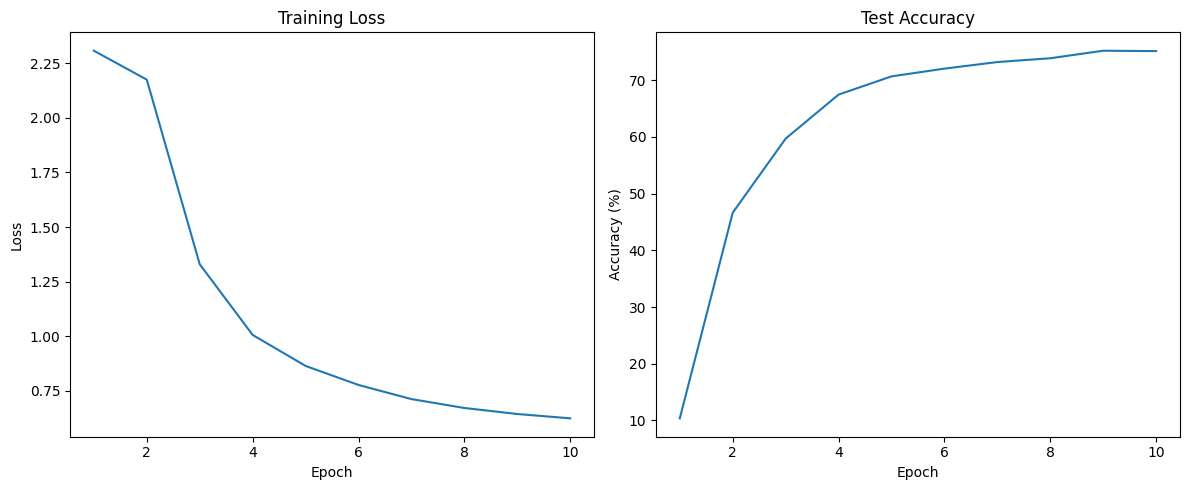

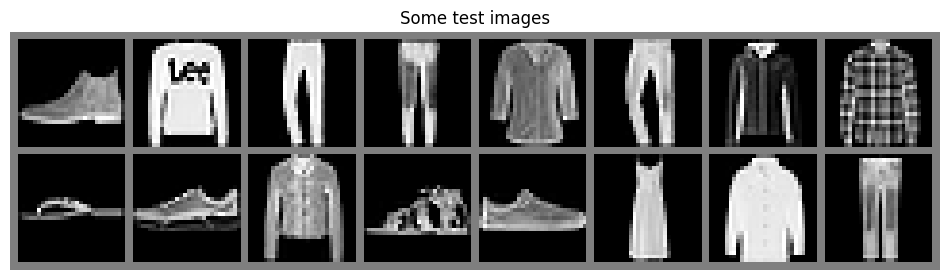

Ground Truth:  Ankle boot Pullover Trouser Trouser Shirt Trouser  Coat Shirt Sandal Sneaker  Coat Sandal Sneaker Dress  Coat Trouser
Predicted:  Ankle boot Pullover Trouser Trouser Pullover Trouser Pullover Pullover Sandal Sneaker  Coat Sandal Sandal Dress  Coat Trouser


In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# LeNet 모델 정의
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
            nn.Linear(120, 84), nn.Sigmoid(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# CNN 가중치 초기화
def init_cnn(module):
    if isinstance(module, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_uniform_(module.weight)

# Fashion-MNIST 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# 클래스 이름 정의
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 모델, 손실 함수, 옵티마이저 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)
model.apply(init_cnn)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# 훈련 결과를 저장할 리스트
train_losses = []
test_accuracies = []

# 훈련 루프
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    # 테스트 세트에서 평가
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Test Accuracy: {accuracy:.2f}%')

print('Training finished!')

# 훈련 손실과 테스트 정확도 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

# 이미지 표시 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# 테스트 세트에서 랜덤 이미지 선택
dataiter = iter(test_loader)
images, labels = next(dataiter)

# 선택된 이미지에 대한 예측
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

# 이미지와 예측 결과 시각화
plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images[:16]))
plt.title('Some test images')
plt.axis('off')
plt.show()

print('Ground Truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(16)))